# NAO example notebook

This notebook contains an example of data access of nextGEMS cycle 3 data with the `Reader` class and evaluation of the NAO teleconnection with `aqua` libraries and examples of the plotting routines.

In [2]:
import sys
from aqua import Reader
from aqua.slurm import slurm
sys.path.insert(0, '../') # Hack to import from parent directory, to be removed
from index import station_based_index
from plots import index_plot, reg_plot
from tools import load_namelist

# IFS data
## tco1279-orca025

In [5]:
diagname  = 'teleconnections'
telecname = 'NAO'

model = 'IFS'
exp = 'tco1279-orca025-cycle3'
source = '2D_monthly_native'

namelist = load_namelist(diagname)

field = namelist[telecname]['field']

In [3]:
# If we want to run ICON data it's better to use the slurm utilities
slurm.job()

2023-06-19 17:44:25 :: create_folder :: WARNING  -> Folder ./slurm already exists
2023-06-19 17:44:25 :: create_folder :: WARNING  -> Folder ./slurm/logs already exists
2023-06-19 17:44:25 :: create_folder :: WARNING  -> Folder ./slurm/output already exists
/work/bb1153/b382289/mambaforge/envs/teleconnections/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36169 instead
  warnings.warn(
2023-06-19 17:44:32 :: slurm :: WARNING  -> #!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -A bb1153
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=10G
#SBATCH -t 02:30:00
#SBATCH --error=./slurm/logs/dask-worker-%j.err
#SBATCH --output=./slurm/output/dask-worker-%j.out

/work/bb1153/b382289/mambaforge/envs/teleconnections/bin/python -m distributed.cli.dask_worker tcp://136.172.124.4:40885 --nthreads 1 --memory-limit 9.31GiB --name dummy-name --nanny -

In [3]:
reader_1279 = Reader(model=model,exp=exp,source=source,regrid='r025')
data = reader_1279.retrieve(var=field)
infile = data[field]
infile = reader_1279.regrid(infile)
infile

2023-06-19 14:12:23 :: Reader :: WARNING  -> No fixes available for model IFS, experiment tco1279-orca025-cycle3, source 2D_monthly_native


<xarray.DataArray 'msl' (time: 60, lat: 720, lon: 1440)>
dask.array<reshape, shape=(60, 720, 1440), dtype=float64, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-15 2020-02-15 ... 2024-12-15
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes: (12/18)
    paramId:                    151
    dataType:                   fc
    numberOfPoints:             6599680
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   avg
    ...                         ...
    missingValue:               3.4028234663852886e+38
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    regridded:                  1
    history:                    2023-06-19 14:12:26 regridded by AQUA regridd...

## Index evaluation

The NAO index can be evaluated by using the library function `station_based_index` from the `index.py` file.

The index can be evaluated with a custom rolling window to average data (standard is 3 months, here written explicitely for sake of clarity).

The function returns a `DataArray` with the timeserie of index values.

In [4]:
nao_1279 = station_based_index(infile,namelist,telecname,months_window=3,
                               loglevel='INFO')
nao_1279

2023-06-19 14:12:30 :: station based index :: INFO     -> Evaluating station based index for NAO
2023-06-19 14:12:30 :: station based index :: INFO     -> Data longitudes are 0-360, converting teleconnection coords
2023-06-19 14:12:30 :: station based index :: INFO     -> Station 1: lon = 334.3, lat = 37.7
2023-06-19 14:12:30 :: station based index :: INFO     -> Station 2: lon = 338, lat = 64.1
2023-06-19 14:12:44 :: station based index :: INFO     -> Index evaluated


<xarray.DataArray 'index' (time: 58)>
dask.array<getitem, shape=(58,), dtype=float64, chunksize=(3,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-02-15 2020-03-15 ... 2024-11-15
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 1 ... 1 2 3 4 5 6 7 8 9 10 11
Attributes: (12/18)
    paramId:                    151
    dataType:                   fc
    numberOfPoints:             6599680
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   avg
    ...                         ...
    missingValue:               3.4028234663852886e+38
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    regridded:                  1
    history:                    2023-06-19 14:12:26 regridded by AQUA regridd...

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'NAO index'}, xlabel='time', ylabel='index [Pa]'>)

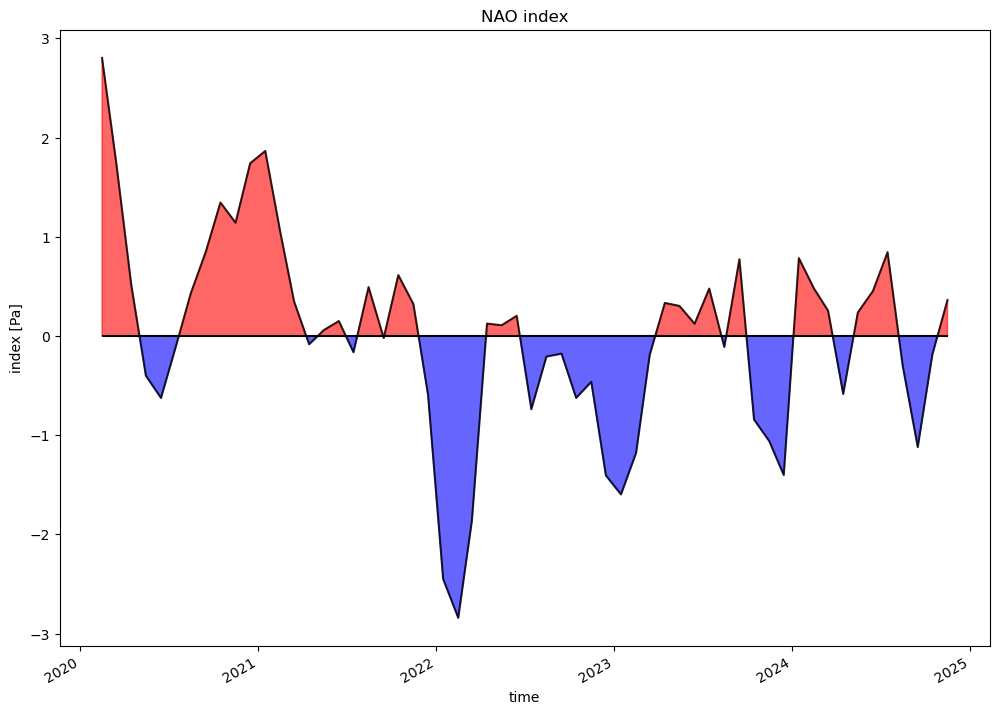

In [5]:
index_plot(nao_1279,title='NAO index',xlabel='time')

## Regression plot

To visualize the teleconnection on a 2D plot, functions in the `plots.py` are introduced.
There is an option `plot=True` that creates a plot of the regression. Additionally an xarray containing the result of the regression is returned, if needed for further analysis or storage.
A custom projection can be specified, here the `LambertConformal` projection is used.

(<xarray.DataArray (lat: 720, lon: 1440)>
 dask.array<truediv, shape=(720, 1440), dtype=float64, chunksize=(720, 1440), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
   * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
 Attributes: (12/18)
     paramId:                    151
     dataType:                   fc
     numberOfPoints:             6599680
     typeOfLevel:                surface
     stepUnits:                  1
     stepType:                   avg
     ...                         ...
     missingValue:               3.4028234663852886e+38
     totalNumber:                0
     NV:                         0
     gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
     regridded:                  1
     history:                    2023-06-15 10:36:30 regridded by AQUA regridd...,
 <Figure size 800x400 with 2 Axes>,
 <GeoAxes: title={'center': 'NAO index'}, xlabel='long

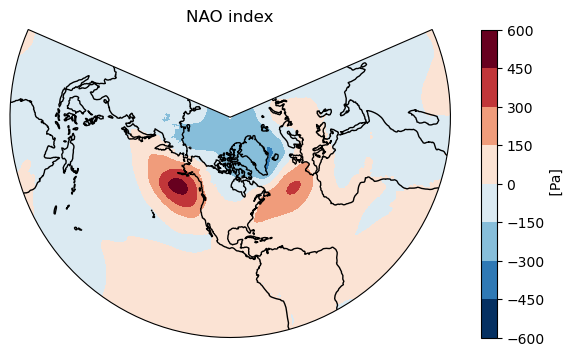

In [7]:
reg_plot(nao_1279,infile,save=False,projection_type='LambertConformal',title='NAO index',contour=True,levels=10)

## IFS 2559

In [6]:
model = 'IFS'
exp = 'tco2559-ng5-cycle3'
source = 'lra-r100-monthly'

reader_2559 = Reader(model=model,exp=exp,source=source)

data = reader_2559.retrieve(var=field)
infile = data[field]
infile

2023-06-19 14:14:34 :: Reader :: WARNING  -> No fixes available for model IFS, experiment tco2559-ng5-cycle3, source lra-r100-monthly


<xarray.DataArray 'msl' (time: 60, lat: 180, lon: 360)>
dask.array<concatenate, shape=(60, 180, 360), dtype=float64, chunksize=(12, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-15 2020-02-15 ... 2024-12-15
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes: (12/17)
    paramId:                    151
    dataType:                   fc
    numberOfPoints:             1038240
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   avg
    ...                         ...
    cfVarName:                  msl
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Latitude/Longitude Grid
    history:                    2023-05-29 14:44:25 resampled to frequency 1M...

2023-06-19 14:14:39 :: station based index :: INFO     -> Evaluating station based index for NAO
2023-06-19 14:14:39 :: station based index :: INFO     -> Data longitudes are 0-360, converting teleconnection coords
2023-06-19 14:14:39 :: station based index :: INFO     -> Station 1: lon = 334.3, lat = 37.7
2023-06-19 14:14:39 :: station based index :: INFO     -> Station 2: lon = 338, lat = 64.1
2023-06-19 14:14:40 :: station based index :: INFO     -> Index evaluated


(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'NAO index'}, xlabel='time', ylabel='index [Pa]'>)

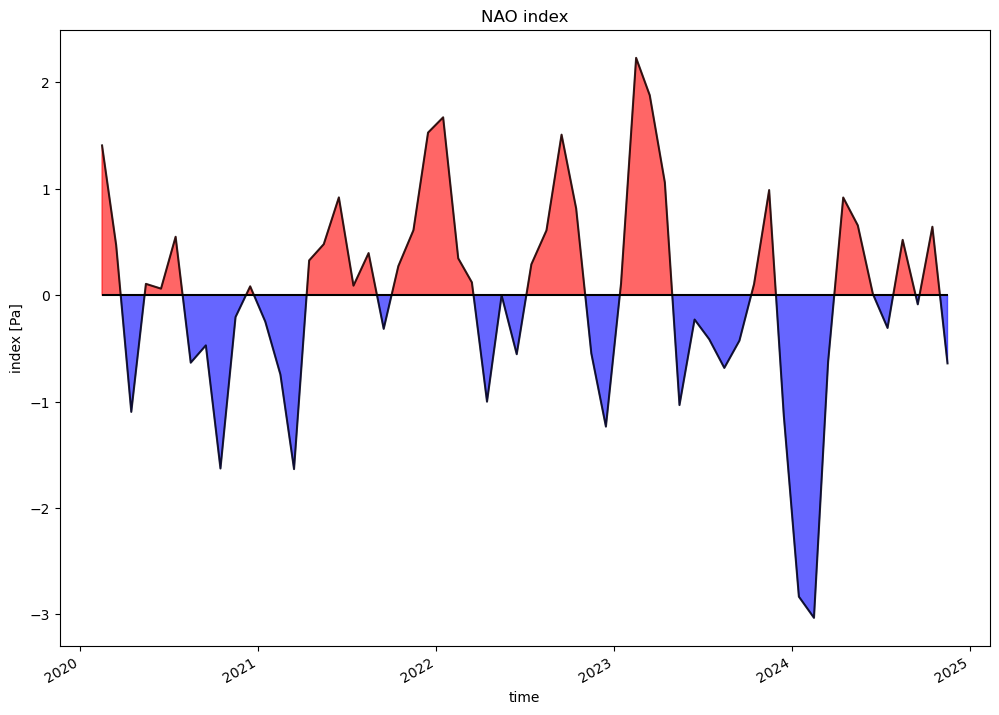

In [7]:
nao_2559 = station_based_index(infile,namelist,telecname,months_window=3,
                               loglevel='INFO')
index_plot(nao_2559,title='NAO index',xlabel='time')

(<xarray.DataArray (lat: 180, lon: 360)>
 dask.array<truediv, shape=(180, 360), dtype=float64, chunksize=(180, 360), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
   * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
 Attributes: (12/17)
     paramId:                    151
     dataType:                   fc
     numberOfPoints:             1038240
     typeOfLevel:                surface
     stepUnits:                  1
     stepType:                   avg
     ...                         ...
     cfVarName:                  msl
     missingValue:               9999
     totalNumber:                0
     NV:                         0
     gridDefinitionDescription:  Latitude/Longitude Grid
     history:                    2023-05-29 14:44:25 resampled to frequency 1M...,
 <Figure size 800x400 with 2 Axes>,
 <GeoAxes: title={'center': 'NAO index'}, xlabel='longitude [degrees_east]

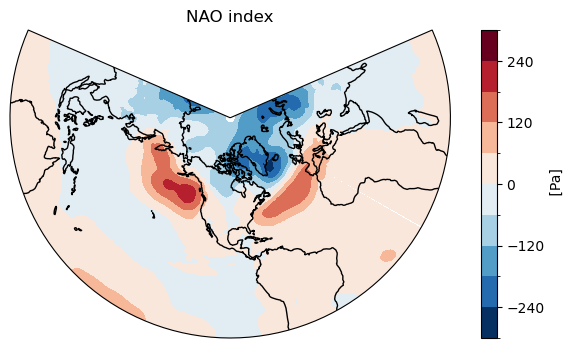

In [10]:
reg_plot(nao_2559,infile,save=False,projection_type='LambertConformal',title='NAO index',contour=True,
         levels=10)

## ICON 3026

Note that for this source we make use of both the regridding and temporal aggregation functionality of the `Reader` class.

In [6]:
model = 'ICON'
exp = 'ngc3026'
source = 'P1D'

reader_3026 = Reader(model=model,exp=exp,source=source,zoom=8,
                     freq='monthly',regrid='r100')

data = reader_3026.retrieve(var=field)
infile = data[field]
infile = reader_3026.timmean(infile)
infile = reader_3026.regrid(infile)
infile

<xarray.DataArray 'msl' (time: 13, lat: 180, lon: 360)>
dask.array<reshape, shape=(13, 180, 360), dtype=float64, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-21 2020-02-01 ... 2021-01-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes:
    cell_methods:  time: mean cell: mean
    component:     atmo
    grid_mapping:  crs
    long_name:     Mean sea level pressure
    units:         Pa
    vgrid:         meansea
    history:       2023-06-19 17:48:04 variable renamed by AQUA fixer;\n2023-...
    paramId:       151
    cfVarName:     msl
    shortName:     msl
    regridded:     1

As it is possible to see we have only one year of data, so the index is not very meaningful.

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'NAO index'}, xlabel='time', ylabel='Mean sea level pressure [Pa]'>)

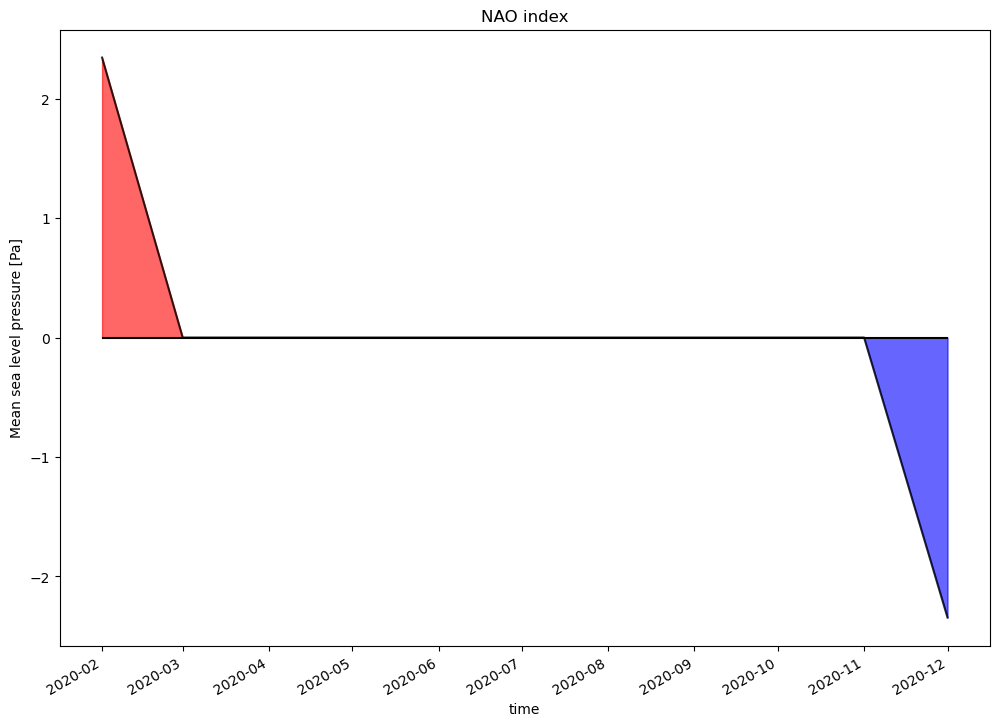

In [7]:
nao_3026 = station_based_index(infile,namelist,telecname,months_window=3)
index_plot(nao_3026,title='NAO index',save=False,xlabel='time')

We can proceed with the last ICON simulation, where we have 5 years of data and the NAO evaluation is more meaningful.

## ICON 3028

In [10]:
model = 'ICON'
exp = 'ngc3028'
source = 'P1D'

reader_3028 = Reader(model=model,exp=exp,source=source,zoom=6,freq='monthly',regrid='r100')

data = reader_3028.retrieve(var=field)
infile = data[field]
infile = reader_3028.timmean(infile)
infile = reader_3028.regrid(infile)
infile

<xarray.DataArray 'msl' (time: 67, lat: 180, lon: 360)>
dask.array<reshape, shape=(67, 180, 360), dtype=float64, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-21 2020-02-01 ... 2025-07-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes:
    cell_methods:  time: mean cell: mean
    component:     atmo
    grid_mapping:  crs
    long_name:     Mean sea level pressure
    units:         Pa
    vgrid:         meansea
    history:       2023-06-19 18:04:36 variable renamed by AQUA fixer;\n2023-...
    paramId:       151
    cfVarName:     msl
    shortName:     msl
    regridded:     1

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'NAO index'}, xlabel='time', ylabel='Mean sea level pressure [Pa]'>)

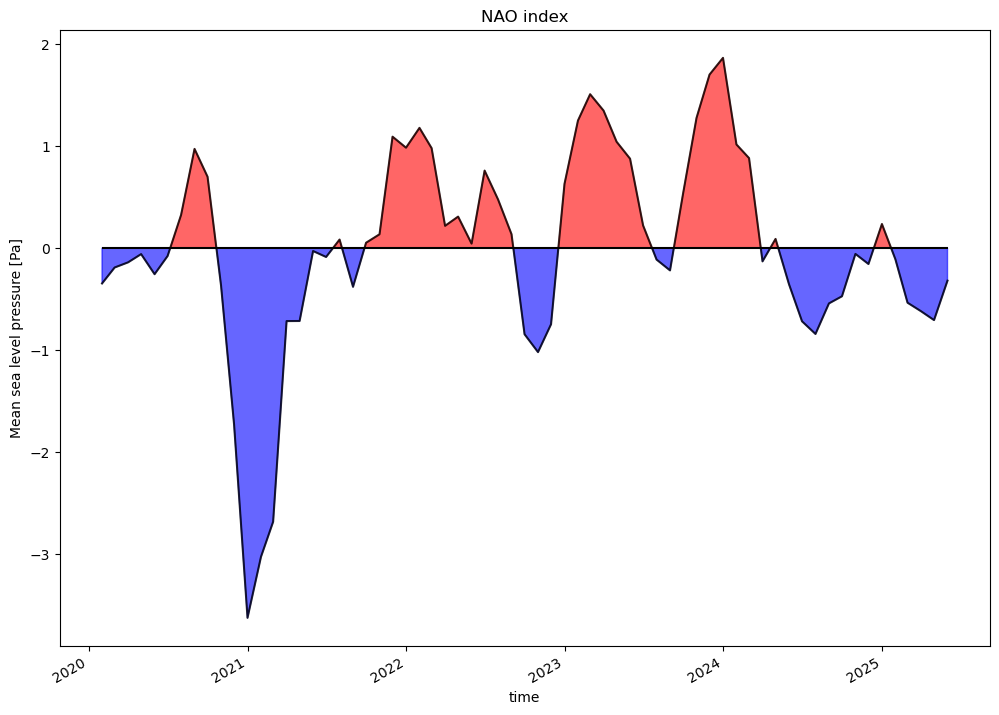

In [11]:
nao_3028 = station_based_index(infile,namelist,telecname,months_window=3)
index_plot(nao_3028,title='NAO index',save=False,xlabel='time')

(<xarray.DataArray (lat: 180, lon: 360)>
 dask.array<truediv, shape=(180, 360), dtype=float64, chunksize=(180, 360), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
   * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
 Attributes:
     cell_methods:  time: mean cell: mean
     component:     atmo
     grid_mapping:  crs
     long_name:     Mean sea level pressure
     units:         Pa
     vgrid:         meansea
     history:       2023-06-15 10:48:01 variable renamed by AQUA fixer;\n2023-...
     paramId:       151
     cfVarName:     msl
     shortName:     msl
     regridded:     1,
 <Figure size 800x400 with 2 Axes>,
 <GeoAxes: title={'center': 'NAO index'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

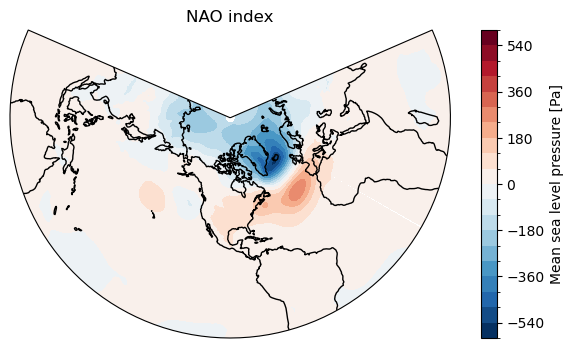

In [8]:
reg_plot(nao_3028,infile,save=False,projection_type='LambertConformal',title='NAO index',contour=True,levels=20)

In [12]:
# We now close the slurm job
slurm.scancel()

slurm_load_jobs error: Socket timed out on send/recv operation
